In [21]:
import os
import pandas as pd
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
from category_encoders.target_encoder import TargetEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


# Loading and cleaning data

In [57]:
# data_train = pd.read_csv("train.csv", nrows=100000).rename(
data_train = pd.read_csv("train.csv").rename(
    columns={"opeartingSystem": "operatingSystem"}).fillna("unknown")

data_test = pd.read_csv("test.csv").rename(
    columns={"opeartingSystem": "operatingSystem"}).fillna("unknown")

data_train.head(2)

,auctionId,timeStamp,placementId,websiteId,hashedRefererDeepThree,country,operatingSystem,browser,browserVersion,device,environmentType,integrationType,articleSafenessCategorization,isSold
0,001ed16b-dd08-4599-b8ef-4f56a373c454_6e5f1087-...,1603815466,120706,68203,1ae7c2d3c28b711c072d8e2eb3869fa59090669bdc153e...,US,Windows,Chrome,86_0,PC,js-web,2,safe,False
1,0024b36a-4fb5-4070-88fb-fc0bfb1909ed,1603974586,69454,42543,df1108bf6ae49dbccf5eab60ff9d04a6a09dda60ec7290...,RO,Android,Facebook App,293_0,Phone,js-fbwv,1,unsafe,False


## Feature engineering

<AxesSubplot:xlabel='timeStamp_hour', ylabel='Count'>

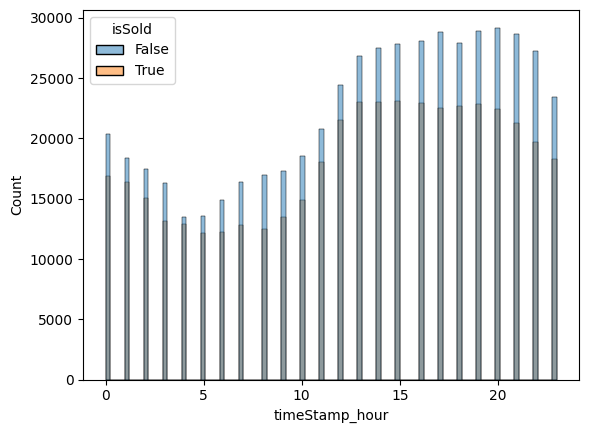

In [58]:
# Not necessarily high correlation 
# sns.histplot(data_train, x="timeStamp", hue="isSold")

for df in [data_train, data_test]:
    df["timeStamp"] = pd.to_datetime(df["timeStamp"], unit='s')
    df["timeStamp_day"] = df["timeStamp"].apply(lambda date: date.day)
    df["timeStamp_hour"] = df["timeStamp"].apply(lambda date: date.hour)

sns.histplot(data_train, x="timeStamp_hour", hue="isSold")

## Split train and test data

In [59]:
features = ["placementId", "websiteId", "country", "operatingSystem", "browser", 
                 "browserVersion", "device", "environmentType", "integrationType",
                 "articleSafenessCategorization", "timeStamp_hour", "timeStamp_day"]

X_train = data_train[features]
y_train = data_train["isSold"]

X_test = data_test[features]

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967332 entries, 0 to 967331
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   placementId                    967332 non-null  int64 
 1   websiteId                      967332 non-null  int64 
 2   country                        967332 non-null  object
 3   operatingSystem                967332 non-null  object
 4   browser                        967332 non-null  object
 5   browserVersion                 967332 non-null  object
 6   device                         967332 non-null  object
 7   environmentType                967332 non-null  object
 8   integrationType                967332 non-null  int64 
 9   articleSafenessCategorization  967332 non-null  object
 10  timeStamp_hour                 967332 non-null  int64 
 11  timeStamp_day                  967332 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 88.6+ M

In [60]:
for col in data_train.columns:
    print(col, "====", len(data_train[col].unique()))

auctionId ==== 967332
timeStamp ==== 473036
placementId ==== 11162
websiteId ==== 7315
hashedRefererDeepThree ==== 127625
country ==== 216
operatingSystem ==== 15
browser ==== 121
browserVersion ==== 640
device ==== 4
environmentType ==== 14
integrationType ==== 2
articleSafenessCategorization ==== 3
isSold ==== 2
timeStamp_day ==== 7
timeStamp_hour ==== 24


## Generate more synthetic True samples - not used now

In [26]:
# from imblearn.over_sampling import SMOTE, SMOTENC

# sm = SMOTE(sampling_strategy=1.0)
# X_train_train, y_train_train = sm.fit_resample(X_train_train, y_train_train)
# X_train_train, y_train_train = sm.fit_resample(X_train_train, y_train_train)

# sm = SMOTENC(categorical_features=[2,3,4,5,6,7,8,10], sampling_strategy=1.0)
# sm.fit_resample(X_train.iloc[:100000], y_train.iloc[:100000])

## Downsample - not used now

In [61]:
X_train_not_sold = X_train[y_train == False]
X_train_sold = X_train[y_train == True]

X_train_downsampled = resample(X_train_not_sold,
                                replace = False, # sample without replacement
                                n_samples = len(X_train_sold))

# combine minority and downsampled majority
X_train_downsampled = pd.concat([X_train_downsampled, X_train_sold])
y_train_downsampled = pd.Series([False for _ in range(len(X_train_sold))] + [True for _ in range(len(X_train_sold))]) 

# checking counts
y_train_downsampled.value_counts()

False    433907
True     433907
Name: count, dtype: int64

In [62]:
# X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train)
X_train_train, X_train_test, y_train_train, y_train_test = \
    train_test_split(X_train_downsampled, y_train_downsampled)


# Preprocessing pipeline

In [63]:
# target_encoder = TargetEncoder().fit(X_train["hashedRefererDeepThree"], y_train)

In [64]:
onehot_features = ["country", "operatingSystem", "browser", 
      "device", "environmentType", "articleSafenessCategorization", "browserVersion", 
      "placementId", "websiteId", ]
targetenc_features = ["hashedRefererDeepThree"]
scaler_features = ["integrationType", "timeStamp_day", "timeStamp_hour"]

preprocessor = ColumnTransformer([
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"), onehot_features),
    #  ("target_encoder", make_pipeline(TargetEncoder(), StandardScaler()), targetenc_features),
    #  ("standard_scaler", StandardScaler(), scaler_features)
], remainder="passthrough")

In [65]:
# parameter_space = {
#     'hidden_layer_sizes': [(10,30,10),(20,)],
#     'activation': ['relu'],
#     'solver': ['adam'],
#     'alpha': [0.0001, 0.005],
#     'learning_rate': ['constant','adaptive'],
# }


model = Pipeline([
    ("preprocessor", preprocessor),
    # ("kmeans", KMeans(n_clusters=2, max_iter=200))
    # ("random_forest", RandomForestClassifier(n_estimators=100, 
                                            #  max_depth=20))
    # ("random_forest", RandomForestClassifier())
    ("logistic_regression", LogisticRegression(max_iter=10000))
    # ("svm", SVC(kernel="linear"))
    # ("mlp", MLPClassifier(hidden_layer_sizes=[90, 90], 
    #                       learning_rate="adaptive", 
    #                       ))
    # ("gridsearch", GridSearchCV(MLPClassifier(), parameter_space, n_jobs=-1, cv=5))
])

In [66]:
# preprocessor test
res = preprocessor.fit_transform(X_train_train, y_train_train)
for i, line in enumerate(preprocessor.get_feature_names_out()):
    print(i, line)
# res.toarray()[0]

0 one_hot_encoder__country_AD
1 one_hot_encoder__country_AE
2 one_hot_encoder__country_AG
3 one_hot_encoder__country_AI
4 one_hot_encoder__country_AL
5 one_hot_encoder__country_AM
6 one_hot_encoder__country_AO
7 one_hot_encoder__country_AR
8 one_hot_encoder__country_AS
9 one_hot_encoder__country_AT
10 one_hot_encoder__country_AU
11 one_hot_encoder__country_AW
12 one_hot_encoder__country_AX
13 one_hot_encoder__country_AZ
14 one_hot_encoder__country_BA
15 one_hot_encoder__country_BB
16 one_hot_encoder__country_BD
17 one_hot_encoder__country_BE
18 one_hot_encoder__country_BF
19 one_hot_encoder__country_BG
20 one_hot_encoder__country_BH
21 one_hot_encoder__country_BI
22 one_hot_encoder__country_BJ
23 one_hot_encoder__country_BM
24 one_hot_encoder__country_BN
25 one_hot_encoder__country_BO
26 one_hot_encoder__country_BQ
27 one_hot_encoder__country_BR
28 one_hot_encoder__country_BS
29 one_hot_encoder__country_BT
30 one_hot_encoder__country_BW
31 one_hot_encoder__country_BZ
32 one_hot_encoder

# Fitting the model and prediction

In [67]:
model.fit(X_train_train, y_train_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'operatingSystem',
                                                   'browser', 'device',
                                                   'environmentType',
                                                   'articleSafenessCategorization',
                                                   'browserVersion',
                                                   'placementId',
                                                   'websiteId'])])),
                ('logistic_regression', LogisticRegression(max_iter=10000))])

In [68]:
y_train_pred = model.predict(X_train_test)
print("Accuracy: ", accuracy_score(y_train_test, y_train_pred))
print("F1 Score: ", f1_score(y_train_test, y_train_pred))

Accuracy:  0.7775104400011063
F1 Score:  0.7784844980450466


# Results

[Text(0.5, 23.52222222222222, 'Predicted label'),
 Text(50.722222222222214, 0.5, 'True label')]

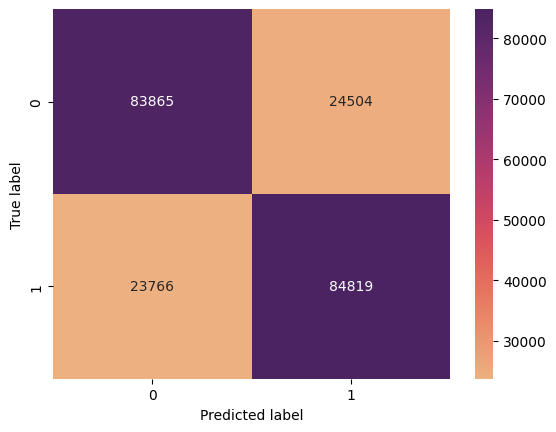

In [69]:
cm = confusion_matrix(y_train_test, y_train_pred)
sns.heatmap(cm, annot=True, cmap=sns.color_palette("flare", as_cmap=True), 
            fmt='d').set(xlabel="Predicted label", ylabel="True label")

In [71]:
y_pred = model.predict(X_test)
submission = data_test[["auctionId"]].copy()
submission["isSold"] = y_pred
submission["isSold"] = submission["isSold"].map({True: 'true', False: 'false'}) 
submission.to_csv("submission.csv", index=False)